In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import community.community_louvain as cl
import matplotlib.cm as cm
import pandas as pd

# Data importing & Year spliting

2021년 데이터의 경우 8월까지의 수출입 데이터가 존재하고, 2021년 9월 이후의 데이터는 아직 정리되지 않은 상황이다.

In [3]:
df = pd.read_csv('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Data/comtradedata/df_2006_2021_1001.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30832 entries, 0 to 30831
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         30832 non-null  int64 
 1   Year               30832 non-null  int64 
 2   From               30832 non-null  object
 3   To                 30832 non-null  object
 4   Trade Value (US$)  30832 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [4]:
df['Year'].value_counts().sort_index()

2006    1852
2007    1844
2008    2019
2009    1980
2010    2113
2011    1665
2012    1630
2013    1697
2014    1690
2015    1849
2016    2193
2017    2257
2018    2164
2019    2219
2020    2107
2021    1553
Name: Year, dtype: int64

In [5]:
wheat_data = {}

startYear = min(df['Year'])
endYear = max(df['Year'])
print(f'Dataset from {startYear} to {endYear}\n')

for year in range(startYear, endYear+1):
    wheat_data[ str(year) ] = df.loc[df['Year'] == year].copy()
    print(year, '\t', wheat_data[ str(year) ].shape)

wheat_data['2017'] # example

Dataset from 2006 to 2021

2006 	 (1852, 5)
2007 	 (1844, 5)
2008 	 (2019, 5)
2009 	 (1980, 5)
2010 	 (2113, 5)
2011 	 (1665, 5)
2012 	 (1630, 5)
2013 	 (1697, 5)
2014 	 (1690, 5)
2015 	 (1849, 5)
2016 	 (2193, 5)
2017 	 (2257, 5)
2018 	 (2164, 5)
2019 	 (2219, 5)
2020 	 (2107, 5)
2021 	 (1553, 5)


,Unnamed: 0,Year,From,To,Trade Value (US$)
20532,20590,2017,Afghanistan,Slovakia,7
20533,20591,2017,Albania,France,88214
20534,20592,2017,Algeria,France,16745
20535,20593,2017,Algeria,Switzerland,374
20536,20594,2017,Algeria,United Arab Emirates,14
...,...,...,...,...,...
22784,22850,2017,Yemen,United Arab Emirates,20774
22785,22851,2017,Zambia,Malawi,3139
22786,22852,2017,Zimbabwe,"Areas, nes",5280000
22787,22853,2017,Zimbabwe,South Africa,19


In [6]:
# the number of countries reported to UN

for year in range(startYear, endYear+1):
    num = 0 # initialize
    num = pd.concat([wheat_data[str(year)]['From'], wheat_data[str(year)]['To']], ignore_index=True).nunique()
    print(f"In {year}, there were {num} reported countires")

In 2006, there were 202 reported countires
In 2007, there were 203 reported countires
In 2008, there were 204 reported countires
In 2009, there were 202 reported countires
In 2010, there were 205 reported countires
In 2011, there were 196 reported countires
In 2012, there were 196 reported countires
In 2013, there were 196 reported countires
In 2014, there were 199 reported countires
In 2015, there were 196 reported countires
In 2016, there were 200 reported countires
In 2017, there were 205 reported countires
In 2018, there were 204 reported countires
In 2019, there were 206 reported countires
In 2020, there were 198 reported countires
In 2021, there were 188 reported countires


In [7]:
# Whole num/list of countries reported to UN

whole_Clist = pd.concat([df['From'], df['To']], ignore_index=True).unique()
whole_Cnum = len(whole_Clist)

print(np.sort(whole_Clist), '\n\n', whole_Cnum)

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antarctica' 'Antigua and Barbuda' 'Areas, nes' 'Argentina' 'Armenia'
 'Aruba' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain'
 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda'
 'Bhutan' 'Bolivia (Plurinational State of)' 'Bonaire'
 'Bosnia Herzegovina' 'Botswana' 'Bouvet Island' 'Br. Virgin Isds'
 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Bunkers' 'Burkina Faso'
 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Cayman Isds'
 'Central African Rep.' 'Chad' 'Chile' 'China' 'China, Hong Kong SAR'
 'China, Macao SAR' 'Colombia' 'Comoros' 'Congo' 'Cook Isds' 'Costa Rica'
 'Croatia' 'Cuba' 'Curaçao' 'Cyprus' 'Czechia' "Côte d'Ivoire"
 "Dem. People's Rep. of Korea" 'Dem. Rep. of the Congo' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Rep.' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia'
 'FS Micronesia' 'Faeroe Isds' 'Falkland Isds (Malvinas)' 'Fiji

# Network processing

## Graph making

In [8]:
wheat = {}

for year in range(startYear, endYear+1):
    wheat[ str(year) ] = nx.from_pandas_edgelist(wheat_data[ str(year) ], source='From', target='To', 
                                                 edge_attr='Trade Value (US$)', create_using=nx.DiGraph()) # Directed Graph
    print(f'Graph of {year} : {nx.info(wheat[ str(year) ])}')

Graph of 2006 : DiGraph with 202 nodes and 1852 edges
Graph of 2007 : DiGraph with 203 nodes and 1844 edges
Graph of 2008 : DiGraph with 204 nodes and 2019 edges
Graph of 2009 : DiGraph with 202 nodes and 1980 edges
Graph of 2010 : DiGraph with 205 nodes and 2113 edges
Graph of 2011 : DiGraph with 196 nodes and 1665 edges
Graph of 2012 : DiGraph with 196 nodes and 1630 edges
Graph of 2013 : DiGraph with 196 nodes and 1697 edges
Graph of 2014 : DiGraph with 199 nodes and 1690 edges
Graph of 2015 : DiGraph with 196 nodes and 1849 edges
Graph of 2016 : DiGraph with 200 nodes and 2193 edges
Graph of 2017 : DiGraph with 205 nodes and 2257 edges
Graph of 2018 : DiGraph with 204 nodes and 2164 edges
Graph of 2019 : DiGraph with 206 nodes and 2219 edges
Graph of 2020 : DiGraph with 198 nodes and 2107 edges
Graph of 2021 : DiGraph with 188 nodes and 1553 edges


In [9]:
print(wheat['2020']['USA']['Rep. of Korea']['Trade Value (US$)'], '\n')
pd.DataFrame(wheat_data['2020'].loc[(wheat_data['2020'].From == 'USA') & (wheat_data['2020'].To == 'Rep. of Korea')])

722606760 



,Unnamed: 0,Year,From,To,Trade Value (US$)
29056,29143,2020,USA,Rep. of Korea,722606760


In [10]:
# finding independent, moderate, dependent node in Graph
def nodeProportion(G):
  sum_ratio = 0
  all_ratio = {}
  high_nodes = []
  other_nodes = []
  for node in list(G.nodes()):
      sum_ratio += G.out_degree(node, weight='Trade Value (US$)')

  for node in list(G.nodes()):
      ratio = (G.out_degree(node, weight='Trade Value (US$)') / sum_ratio) * 100
      all_ratio[node] =  ratio

  # 세계 수출의 5% 이상을 차지하는 노드 파악
  for node in list(G.nodes()):
    high_nodes.append(node) if all_ratio[node] > 1 else other_nodes.append(node)

  return high_nodes, other_nodes

In [11]:
def DiGraphPlot_all(G, year):
    fig, ax = plt.subplots()
    fig.set_size_inches((64, 64))
    
    plt.rcParams.update({
        "figure.facecolor":  (1.0, 229/255, 204/255, 0.3),  # with alpha = 30%
        "savefig.facecolor": (1.0, 229/255, 204/255, 0.3),  # with alpha = 30%
    })

    # nodelist by dependency
    high_nodes, other_nodes = nodeProportion(G)
    
    ## layout 설정
    layout = {"circular layout of Countries in {}".format(year) : nx.circular_layout(G)}
              
    for _, item in enumerate(layout.items()):
        title, pos = item[0], item[1]
        nx.draw_networkx(G, pos=pos, font_color="white", ax=ax, font_size=8)
        
        # 수입 의존도가 낮은 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = high_nodes,
                               node_color="tab:blue",
                               node_size = 5000)        
        
        # 나머지 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = other_nodes,
                               node_color="black",
                               node_size = 5000)
        
        # arrow style 지정
        nx.draw_networkx_edges(G, pos, edge_color='k', arrowsize=15, connectionstyle='arc3', min_target_margin=30)

        
        ax.set_title(title, fontsize=40)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/worldIMG/worldGraph_in_{year}.png",
                # dpi = 200, # 해상도
                bbox_inches='tight' # 
                )
    plt.show()
    plt.close()

In [12]:
# import time
# from tqdm import tqdm

# # saving each plot images
# for year in tqdm(range(2011, endYear+1), desc = "plotting DiGraph", mininterval=0.01):
#     DiGraphPlot_all(wheat[str(year)], year)

## Structure analysis

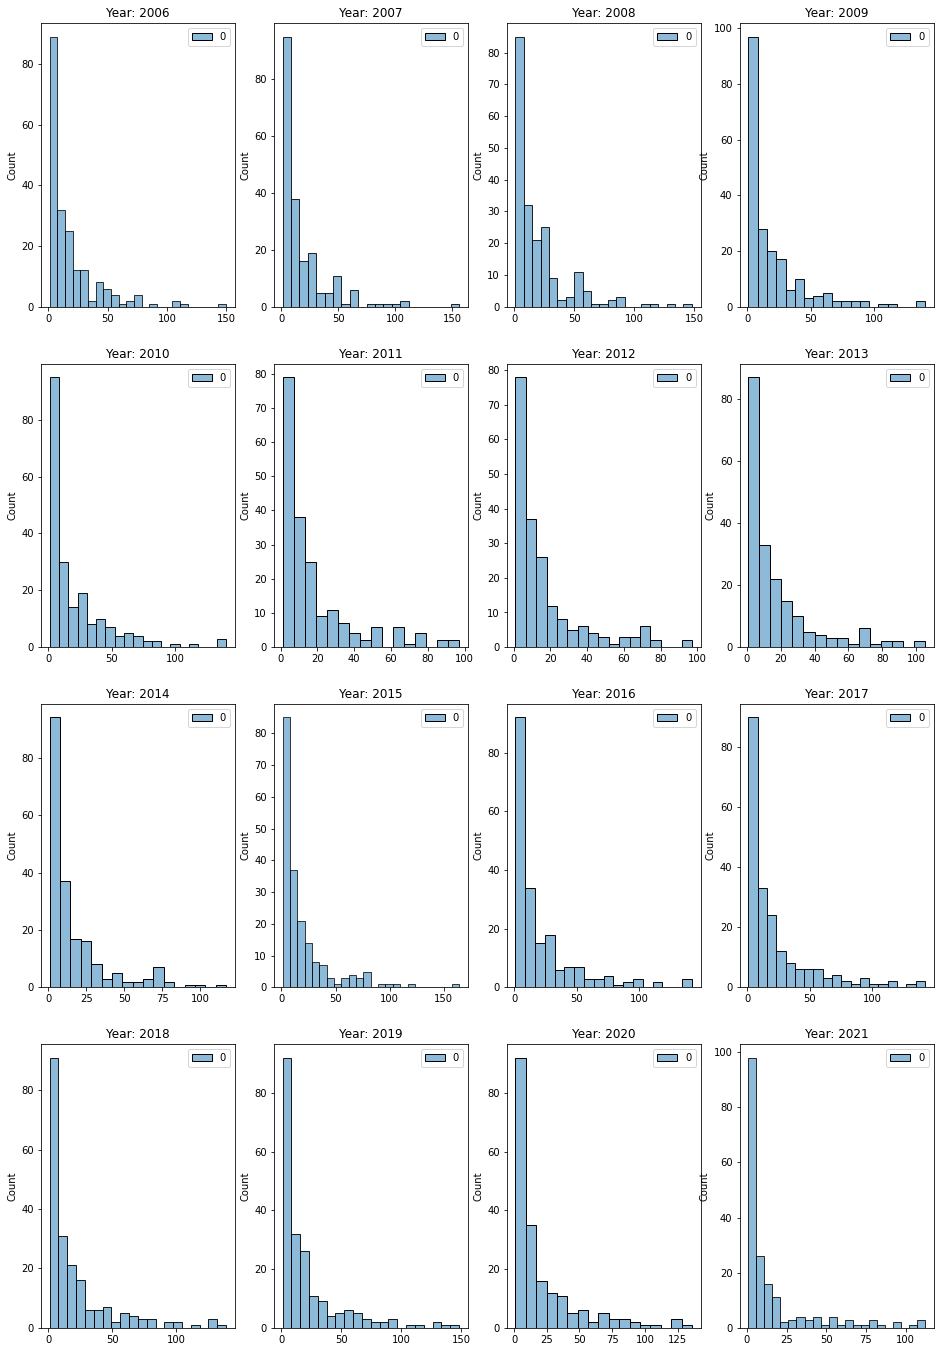

In [13]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 24))
i = 0

for year in range(startYear, endYear+1):
    sns.histplot(dict(nx.degree(wheat[ str(year) ])).values(), ax=ax[i//4, i%4]).set_title(f'Year: {year}')
    i += 1

plt.show()

In [14]:
strInfo = {}
strInfoLst = {'dia': [], 'den': [], 'trans': [], 'recip': []}

for year in range(startYear, endYear+1):
    strInfo[ str(year) ] = {}

    strInfo[ str(year) ]['dia'] = nx.diameter(nx.to_undirected(wheat[ str(year) ]))
    strInfo[ str(year) ]['den'] = nx.density(nx.to_undirected(wheat[ str(year) ]))
    strInfo[ str(year) ]['trans'] = nx.transitivity(nx.to_undirected(wheat[ str(year) ])) # 방향성 제거
    strInfo[ str(year) ]['recip'] = nx.reciprocity(wheat[ str(year) ])

    for key in strInfo[ str(year) ].keys():
        strInfoLst[key].append(strInfo[ str(year) ][key])

In [15]:
Info_df = pd.DataFrame(strInfoLst, index=[i for i in range(startYear, endYear+1)])

Info_df

,dia,den,trans,recip
2006,5,0.091227,0.320869,0.293737
2007,5,0.089938,0.317475,0.312364
2008,5,0.097508,0.332058,0.304111
2009,5,0.097532,0.331290,0.327273
2010,5,0.101052,0.343036,0.326550
2011,5,0.087127,0.298270,0.313514
2012,5,0.085296,0.289223,0.320245
2013,5,0.088802,0.298291,0.304066
2014,5,0.085782,0.308720,0.305325
2015,5,0.096756,0.318202,0.358031


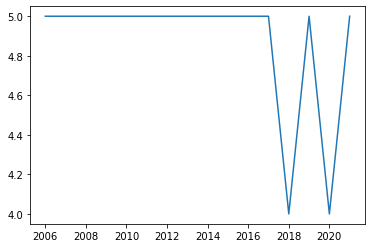

In [16]:
plt.plot(Info_df['dia'])
plt.show()

네트워크에서 가장 멀리 연결된 pair의 거리를 의미하는 diameter의 경우 주로 5의 값을 나타내었고, 2018년과 2020년 한단계가 감소하는 것이 관찰되었다.
다만 2021년의 경우 August까지만 reported 된 점을 감안하였을 때 추가로 9월~ 12월의 데이터가 추가되면 diameter가 4로 감소할 가능성도 있을 것이다.

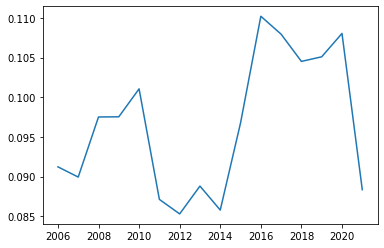

In [17]:
plt.plot(Info_df['den'])
plt.show()

density의 경우 모든 노드 끼리의 가능한 연결 대비 실제 존재하는 엣지수의 비율을 나타내는데, 0.1의 값에서 0.01 정도의 편차로 변화하는 것을 관찰가능하다.
지난 16년간 세계의 밀 무역은 가능한 모든 링크 중 평균적으로 10% 정도가 거래로 이어졌음을 알아볼 수 있다. 이는 각 국가가 주로 교역의 그룹이 존재할 수 있음을 의미하고, 전체 국가들의 집합에서 나누어지는 sub set에서 각각의 거래가 이루어 지기 때문이라는 점을 유추해볼 수 있다.

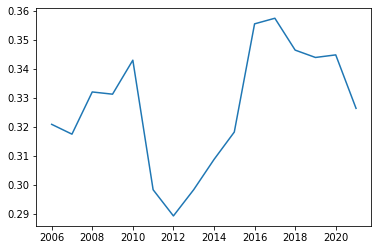

In [18]:
plt.plot(Info_df['trans'])
plt.show()

3개 이상의 국가가 서로 연결된 비율을 나타내는 지표인 transitivity의 경우 역시 지난 16년간 큰 변화를 보이지는 않았다.

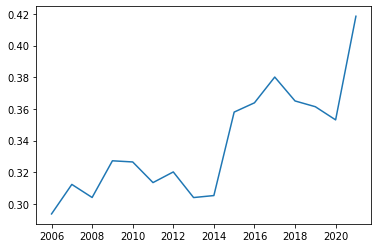

In [19]:
plt.plot(Info_df['recip'])
plt.show()

특이사항으로 지난 16년간 reciprocity(상호성) 지표가 증가하는 모습을 관찰 가능했는데, 이는 과거 각 국가들의 기능이 수입에만 의존하던 단방향 연결만 존재하던 상태에서 다시 거꾸로 수출도 이루어지며 수출을 하는 국가가 조금씩 늘어가고 있다는 점을 시사한다고 볼 수 있다. 이러한 수출 수입을 동시에 하는 국가 다양성의 증가는 더 더 촘촘해지는 global network에서 긍정적인 signal 중 하나로 생각해볼 수 있을 것이다.


## Centrality Analysis

### return_centralities_as_dict()

In [20]:
from networkx.algorithms.centrality.eigenvector import eigenvector_centrality

def return_centralities_as_dict(input_g):
    # weighted degree centrality를 딕셔너리로 리턴
    def return_weighted_degree_centrality(input_g, normalized=False):
        w_d_centrality = {n:0.0 for n in input_g.nodes()} # initialize
        for u, v, d in input_g.edges(data=True):
            w_d_centrality[u]+=d['Trade Value (US$)']
            w_d_centrality[v]+=d['Trade Value (US$)']
        if normalized==True:
            weighted_sum = sum(w_d_centrality.values())
            return {k:v/weighted_sum for k, v in w_d_centrality.items()}
        else:
            return w_d_centrality

    def return_closeness_centrality(input_g):
        new_g_with_distance = input_g.copy()
        for u,v,d in new_g_with_distance.edges(data=True):
            if 'distance' not in d:
                d['distance'] = 1.0/d['Trade Value (US$)']
        return nx.closeness_centrality(new_g_with_distance, distance='distance')

    def return_betweenness_centrality(input_g):
        return nx.betweenness_centrality(input_g, weight='Trade Value (US$)')

    def return_eigenvector_centrality(input_g):
        return nx.eigenvector_centrality(input_g, weight='Trade Value (US$)', max_iter=1000000000000000000000) 
        # max_iter는 default 100으로 설정되어 미지정시 PowerIterationFailedConvergence 에러가 발생

    return {
        'weighted_deg':return_weighted_degree_centrality(input_g),
        'closeness_cent':return_closeness_centrality(input_g), 
        'betweenness_cent':return_betweenness_centrality(input_g),
        'eigenvector_cent':return_eigenvector_centrality(input_g)
    }

In [21]:
cenInfo = {}
# cenInfoLst = {}
# cenInfoLst = {'deg': [], 'wdeg':[], 'bet': [], 'wbet': [], 'clo': [], 'wclo': [], 'eig': [], 'weig': []}

for year in range(startYear, endYear+1):
    cenInfo[str(year)]    = {}
    # cenInfoLst[str(year)] = {'deg': [], 'wdeg':[], 'bet': [], 'wbet': [], 'clo': [], 'wclo': [], 'eig': [], 'weig': []}

    cenInfo[ str(year) ]['deg'] = nx.degree_centrality(wheat[ str(year) ])
    cenInfo[ str(year) ]['wdeg'] = return_centralities_as_dict(wheat[ str(year) ])['weighted_deg']
    cenInfo[ str(year) ]['bet'] = nx.betweenness_centrality(wheat[ str(year) ])
    cenInfo[ str(year) ]['wbet'] = return_centralities_as_dict(wheat[ str(year) ])['betweenness_cent']
    cenInfo[ str(year) ]['clo'] = nx.closeness_centrality(wheat[ str(year) ])
    cenInfo[ str(year) ]['wclo'] = return_centralities_as_dict(wheat[ str(year) ])['closeness_cent']
    cenInfo[ str(year) ]['eig'] = nx.eigenvector_centrality(wheat[ str(year) ])
    cenInfo[ str(year) ]['weig'] = return_centralities_as_dict(wheat[ str(year) ])['eigenvector_cent']

    # for key in cenInfo[str(year)].keys():
        # cenInfoLst[str(year)][key].append(cenInfo[ str(year) ][key])

In [22]:
cenInfo['2021']['deg']

{'Afghanistan': 0.0053475935828877,
 'Albania': 0.0320855614973262,
 'Algeria': 0.0855614973262032,
 'Andorra': 0.0106951871657754,
 'Angola': 0.0374331550802139,
 'Antarctica': 0.0053475935828877,
 'Areas, nes': 0.0481283422459893,
 'Argentina': 0.08021390374331551,
 'Armenia': 0.0427807486631016,
 'Aruba': 0.0213903743315508,
 'Australia': 0.32085561497326204,
 'Austria': 0.2459893048128342,
 'Azerbaijan': 0.0374331550802139,
 'Bahamas': 0.0053475935828877,
 'Bahrain': 0.0106951871657754,
 'Bangladesh': 0.0320855614973262,
 'Barbados': 0.0106951871657754,
 'Belarus': 0.08021390374331551,
 'Belgium': 0.3957219251336898,
 'Belize': 0.0213903743315508,
 'Benin': 0.053475935828877004,
 'Bermuda': 0.0053475935828877,
 'Bhutan': 0.0053475935828877,
 'Bolivia (Plurinational State of)': 0.0320855614973262,
 'Bosnia Herzegovina': 0.0374331550802139,
 'Botswana': 0.0053475935828877,
 'Br. Virgin Isds': 0.0053475935828877,
 'Brazil': 0.06951871657754011,
 'Brunei Darussalam': 0.0053475935828877

In [23]:
for year in range(startYear, endYear+1):

  for key in cenInfo[str(year)].keys():

    print(f"{key} centrality of Korea in {year} : {cenInfo[str(year)][key]['Rep. of Korea']:.4f}")

deg centrality of Korea in 2006 : 0.0995
wdeg centrality of Korea in 2006 : 1014223196.0000
bet centrality of Korea in 2006 : 0.0077
wbet centrality of Korea in 2006 : 0.0269
clo centrality of Korea in 2006 : 0.2761
wclo centrality of Korea in 2006 : 12.6261
eig centrality of Korea in 2006 : 0.0686
weig centrality of Korea in 2006 : 0.0007
deg centrality of Korea in 2007 : 0.0792
wdeg centrality of Korea in 2007 : 1375956319.0000
bet centrality of Korea in 2007 : 0.0076
wbet centrality of Korea in 2007 : 0.0079
clo centrality of Korea in 2007 : 0.2308
wclo centrality of Korea in 2007 : 66.9024
eig centrality of Korea in 2007 : 0.0253
weig centrality of Korea in 2007 : 0.0005
deg centrality of Korea in 2008 : 0.1034
wdeg centrality of Korea in 2008 : 1976610028.0000
bet centrality of Korea in 2008 : 0.0064
wbet centrality of Korea in 2008 : 0.1952
clo centrality of Korea in 2008 : 0.2680
wclo centrality of Korea in 2008 : 625.0632
eig centrality of Korea in 2008 : 0.0521
weig centrality

## wheat(Graph) to pickle

In [24]:
wheat['2021'] # year -> centrality-type -> Country -> value

In [25]:
# import pickle

# with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/wheat.pkl', 'wb') as f:
#   pickle.dump(wheat, f)